In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import sklearn
import collections
from sklearn.model_selection import train_test_split
import json
import pylab
from scipy.optimize import curve_fit
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import matplotlib
import matplotlib.patches as mpatches
import shap
import os
import pandas as pd

2024-07-08 15:27:34.438183: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-08 15:27:34.711687: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set matplotlib default color cycle
new_color_cycle = [
    '#1f77b4',
    '#ff7f0e',
    '#2ca02c',
    '#d62728',
    '#9467bd',
    '#8c564b',
    '#e377c2',
    '#7f7f7f',
    '#bcbd22',
    '#17becf',
    '#aec7e8',
    '#ffbb78',
    '#98df8a',
    '#ff9896',
    '#c5b0d5',
    '#c49c94',
    '#f7b6d2',
    '#c7c7c7',
    '#dbdb8d',
    '#9edae5'
]

# You can then apply this new color cycle to your matplotlib plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=new_color_cycle)

In [3]:
# This is the list that will hold all of the data (data22 and MC)

datasets = {}

In [4]:
datasets = {}

#with h5py.File('../../../../ntuples/AOD_EB_ntuples_05-22-2024.h5', 'r') as hf:
with h5py.File('/eos/home-m/mmcohen/ntuples/EB_473255_ntuples_06-15-2024.h5', 'r') as hf:
    HLT_jets = hf['HLT_jets'][:]
    ofl_jets = hf['ofl_jets'][:]
    L1_jFexSR_jets = hf['L1_jFexSR_jets'][:]
    L1_jFexLR_jets = hf['L1_jFexLR_jets'][:]
    HLT_electrons = hf['HLT_electrons'][:]
    LRT_electrons = hf['LRT_electrons'][:]
    ofl_electrons = hf['ofl_electrons'][:]
    L1_egammas = hf['L1_egammas'][:]
    HLT_muons = hf['HLT_muons'][:]
    LRT_muons = hf['LRT_muons'][:]
    ofl_muons = hf['ofl_muons'][:]
    L1_muons = hf['L1_muons'][:]
    L1_eFex_taus = hf['L1_eFex_taus'][:]
    L1_jFex_taus = hf['L1_jFex_taus'][:]
    HLT_photons = hf['HLT_photons'][:]
    ofl_photons = hf['ofl_photons'][:]
    HLT_MET = hf['HLT_MET'][:].reshape(-1, 1, 3)  # Broadcasting MET
    L1_MET = hf['L1_MET'][:].reshape(-1, 1, 3)
    pass_L1_unprescaled = hf["pass_L1_unprescaled"][:]
    pass_HLT_unprescaled = hf["pass_HLT_unprescaled"][:]
    EB_weights = hf["EB_weights"][:]
    event_number = hf["event_number"][:]
    run_number = hf["run_number"][:]


# Concatenate HLT data
HLT_objects = np.concatenate([HLT_jets[:, :, [0, 2, 3]], HLT_electrons, HLT_muons, HLT_photons, HLT_MET], axis=1)
L1_objects = np.concatenate([L1_jFexSR_jets, L1_egammas, L1_muons, L1_eFex_taus, L1_MET], axis=1)

datasets['EB'] = {
    'HLT_data': HLT_objects,
    'L1_data': L1_objects,
    'passL1': pass_L1_unprescaled==1,
    'passHLT': pass_HLT_unprescaled==1,
    'weights': EB_weights,
    'event_numbers': event_number,
    'run_numbers': run_number
}

In [77]:
# Read MC data.

data_path = '/eos/home-m/mmcohen/ntuples/L1_MC/'

for filename in os.listdir(data_path):

    if filename.startswith('HLT') or filename.startswith('.'): continue

    dataset_tag = filename.split('_')[0]
    
    with h5py.File(data_path+filename, 'r') as hf:
        HLT_jets = hf['HLT_jets'][:]
        L1_jFexSR_jets = hf['L1_jFexSR_jets'][:]
        L1_jFexLR_jets = hf['L1_jFexLR_jets'][:]
        HLT_electrons = hf['HLT_electrons'][:]
        LRT_electrons = hf['LRT_electrons'][:]
        L1_egammas = hf['L1_egammas'][:]
        HLT_muons = hf['HLT_muons'][:]
        LRT_muons = hf['LRT_muons'][:]
        L1_muons = hf['L1_muons'][:]
        L1_eFex_taus = hf['L1_eFex_taus'][:]
        L1_jFex_taus = hf['L1_jFex_taus'][:]
        HLT_photons = hf['HLT_photons'][:]
        HLT_MET = hf['HLT_MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
        L1_MET = hf['L1_MET'][:].reshape(-1, 1, 3)
        pass_L1_unprescaled = hf["pass_L1_unprescaled"][:]
        pass_HLT_unprescaled = hf["pass_HLT_unprescaled"][:]

        HLT_objects = np.concatenate([HLT_jets[:, :, [0, 2, 3]], HLT_electrons[:, :3, [0, 2, 3]], HLT_muons[:, :3, [0, 2, 3]], HLT_photons[:, :3, [0, 2, 3]], HLT_MET[:, :, [0, 2, 3]]], axis=1)
        L1_objects = np.concatenate([L1_jFexSR_jets, L1_egammas[:, :3, :], L1_muons[:, :3, :], L1_eFex_taus[:, :3, :], L1_MET], axis=1)
        
        datasets[dataset_tag] = {
            'HLT_data': HLT_objects,
            'L1_data': L1_objects,
            'passL1': pass_L1_unprescaled==1,
            'passHLT': pass_HLT_unprescaled==1,
            'weights': np.ones(len(HLT_objects)),
        }

In [78]:
print(datasets['EB']['L1_data'].shape)

(1011941, 29, 3)


In [80]:
print(datasets.keys())

dict_keys(['EB', 'A14N23LO', 'HAHMggf', 'HHbbttHadHad', 'ZZ4lep', 'Zprime2EJs', 'jjJZ2', 'jjJZ4', 'qqa'])


In [82]:
print(datasets['EB']['L1_data'][:5, -1, :])
print(datasets['HHbbttHadHad']['L1_data'][:5, -1, :])
print(datasets['HAHMggf']['L1_data'][:5, -1, :])

[[ 3.22490311  0.         -2.08994246]
 [ 3.40587711  0.         -2.27305317]
 [ 4.52548361  0.         -2.3561945 ]
 [ 2.47386336  0.         -2.89661407]
 [ 4.40454292  0.         -2.2597208 ]]
[[36.98215485  0.          0.89267701]
 [32.85361481  0.          0.73372006]
 [28.22268486  0.          0.71016353]
 [36.1137085   0.          0.32700443]
 [75.39230347  0.          0.54678881]]
[[48.29575348  0.          0.87923938]
 [25.83795738  0.          0.0542104 ]
 [51.84360886  0.          0.41704926]
 [11.90966034  0.          0.7140907 ]
 [30.1728363   0.          0.89812577]]


In [65]:
def plot_kinematics(dataset, data_name, var='pt', object='jets'):
    '''Plots a histogram of the variable 'var' across 'object's in 'data'.
    var: should be either 'pt', 'eta', or 'phi'.
    object: should be either 'jets', 'electrons', 'photons', 'muons', or 'MET'.
    label: what the call the histogram in the legend.'''
    plt.figure(figsize=(14, 8))
    plt.rcParams['axes.linewidth'] = 2.4
    
    bins = {'pt': np.linspace(-100, 1800, 55),
            'eta': np.linspace(-5, 5, 35),
            'phi': np.linspace(-np.pi, np.pi, 35)}

    idx_1 = {'jets': 0,
            'electrons': 10,
            'muons': 16,
            'photons': 22,
            'MET': 28}

    idx_2 = {'pt': 0,
            'eta': 1,
            'phi': 2}


    #mask = datasets[data_name]['HLT'][:, idx_1[object], 0] > 0 # require that the event has at least one of the given object
    plt.hist(dataset[data_name]['HLT_data'][:, idx_1[object], idx_2[var]], bins=bins[var], label='HLT_data', histtype='step', density=True, fill=False, linewidth=3, weights=dataset[data_name]['weights'])
    plt.hist(dataset[data_name]['L1_data'][:, idx_1[object], idx_2[var]], bins=bins[var], label='L1_data', histtype='step', density=True, fill=False, linewidth=3, weights=dataset[data_name]['weights'])
    
    plt.yscale('log')
    plt.xlabel(f'{object} {var}', fontsize=22)
    plt.ylabel('density', fontsize=22)
    plt.title(f'Leading {object} {var}', fontsize=30)
    plt.grid()
    plt.legend(fontsize=18)
    plt.show()

In [66]:
# # In the EB sets, only take events that either passed L1, or are L1Seeded

# mask = datasets['EB']['passL1']
# for label, data in datasets['EB'].items():
#     datasets['EB'][label] = data[mask]

# mask = datasets['473255_EB']['passL1']
# for label, data in datasets['473255_EB'].items():
#     datasets['473255_EB'][label] = data[mask]

In [67]:
el_mask = datasets['EB']['HLT_data'][:, 10, 0] != 0
print(f"weighted fraction of events with an HLT electron = {np.sum(el_mask * datasets['EB']['weights']) / np.sum(datasets['EB']['weights'])}")
print(f"unweighted fraction of events with an HLT electron = {np.sum(el_mask) / len(datasets['EB']['weights'])}")

weighted fraction of events with an HLT electron = 0.04526757796253981
unweighted fraction of events with an HLT electron = 0.30293663365749585


In [68]:
"""Multiply the et of the L1 muons by 1000 to get them into the right units."""
for tag, dict in datasets.items():
    for label, data in dict.items():
        if label == 'L1_data':
            data[:, 16:22, 0] *= 1000

In [69]:
# """Multiply the et of the L1 MET by 1000 to get them into the right units."""
# for tag, dict in datasets.items():
#     for label, data in dict.items():
#         if label == 'L1_data':
#             data[:, 28, 0] *= 1000

In [70]:
"""Met bias. For some events, MET was not calculated, so was written as -999."""
for tag, dict in datasets.items():
    for label, data in dict.items():
        if label.endswith('data'):

            MET_zeros = (data[:, 28, 0] == 0) # indices where MET=0
            MET_999 = ((data[:, 28, 0] == -999)) # indices where MET=-999 (not calculated)
            MET_nan = np.isnan(data[:, 28, 2])
            data[MET_zeros, 28, 0] = 0.001
            data[MET_999, 28, :] = -2
            data[MET_nan, 28, :] = -2

In [71]:
print(np.sum(datasets['EB']['L1_data'][:, 16, 0] > 0))

print(datasets['EB']['L1_data'][:, 16, 0][100:110])

203678
[14.99999966  0.          0.          0.          4.00000019  6.00000005
  0.          0.         14.99999966  8.00000038]


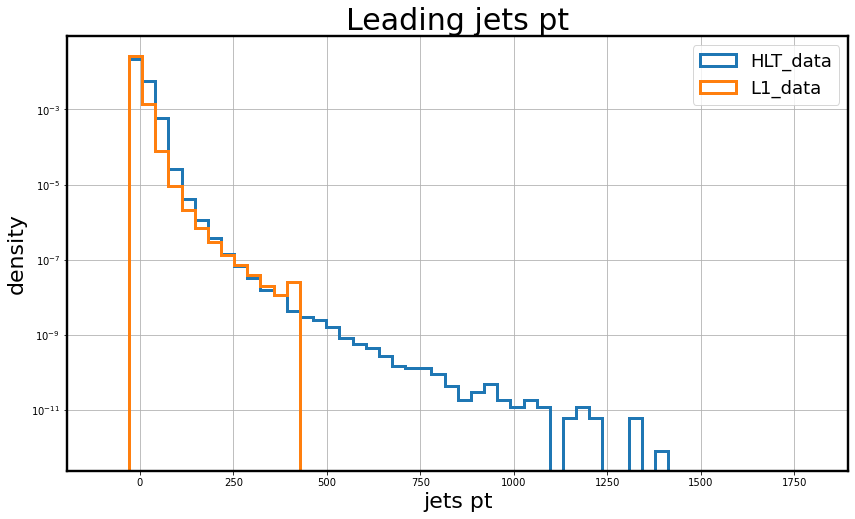

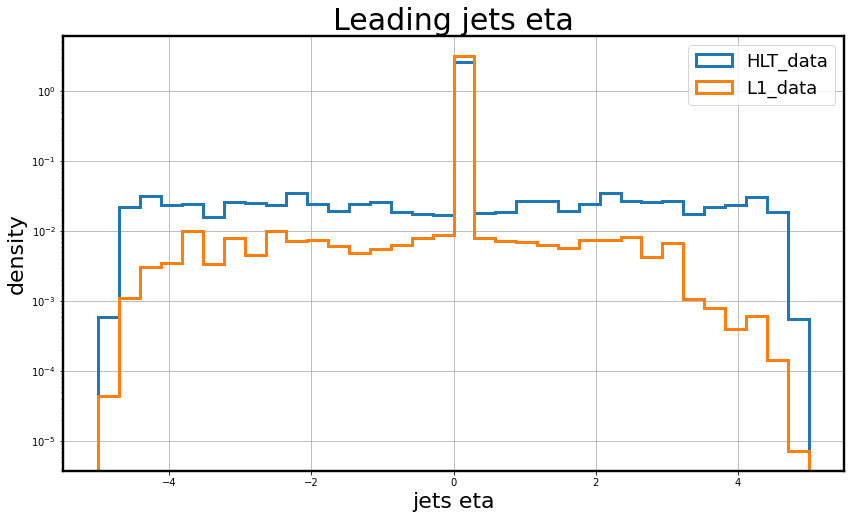

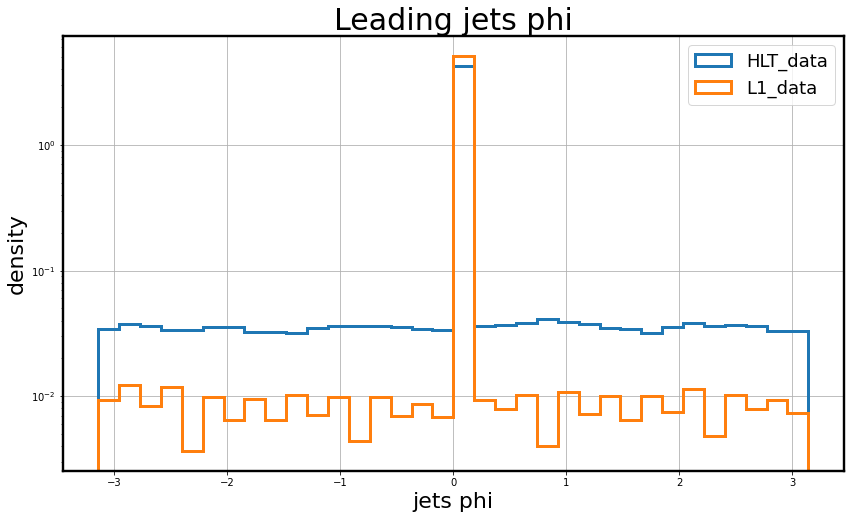

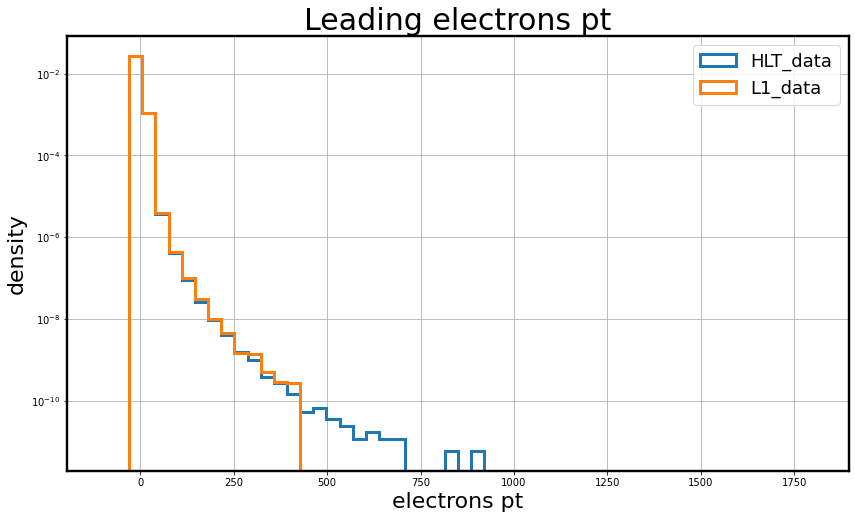

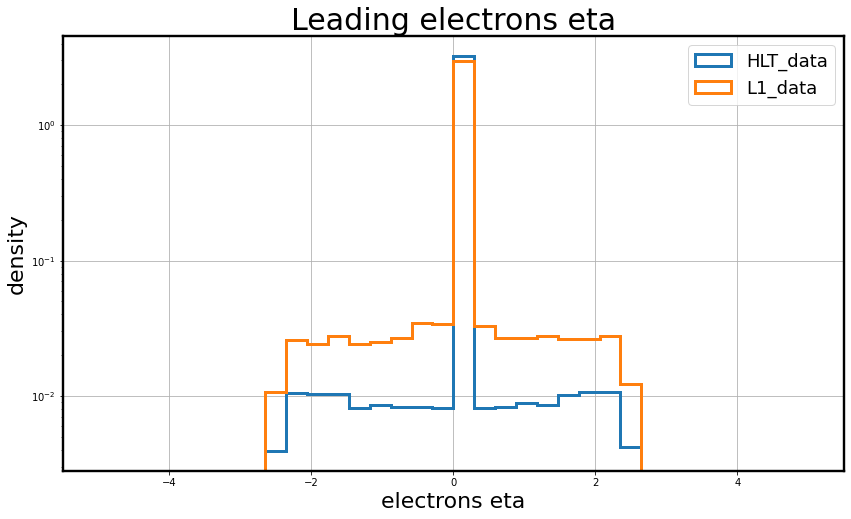

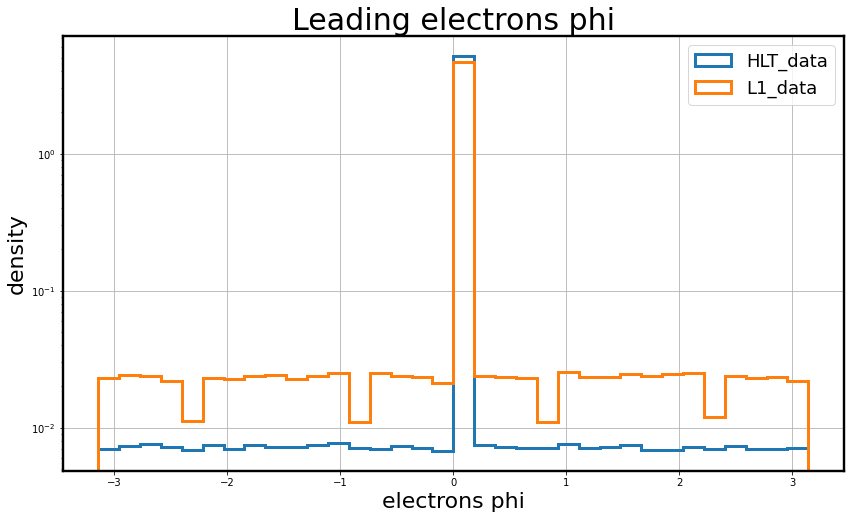

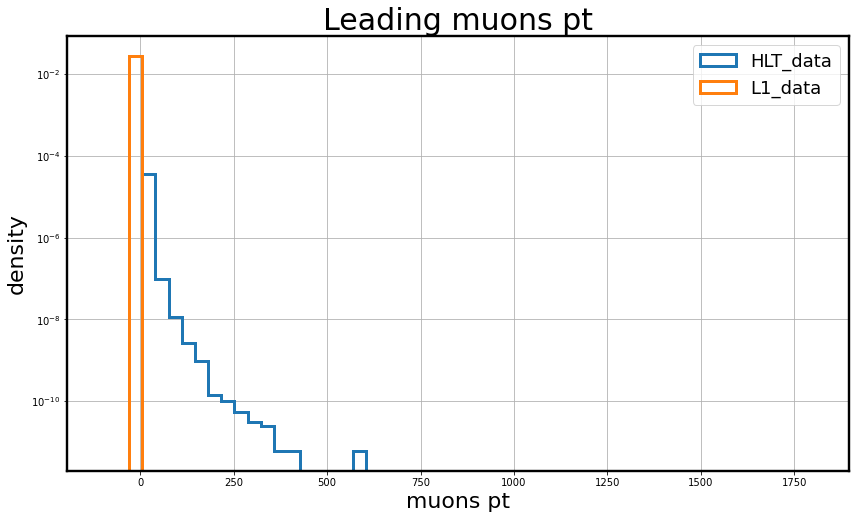

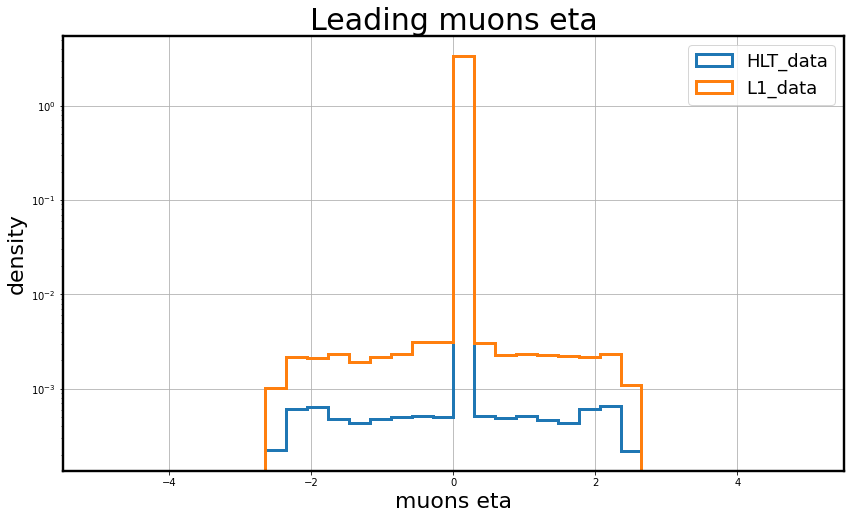

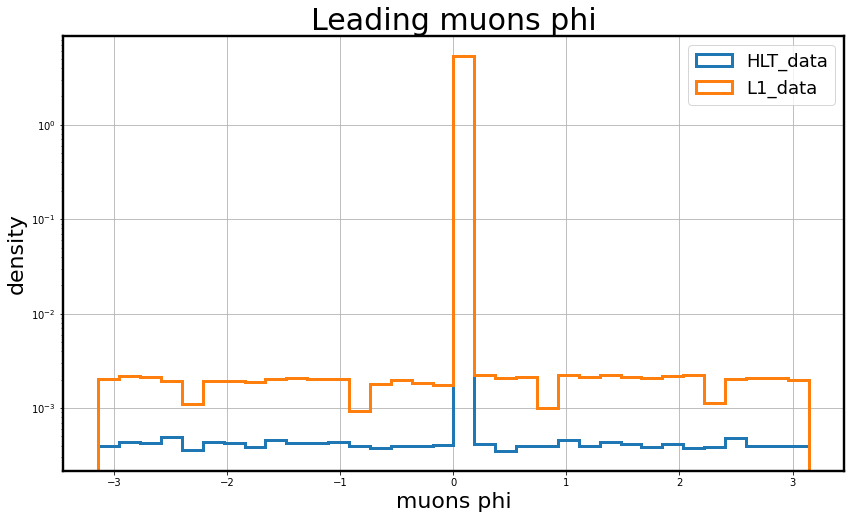

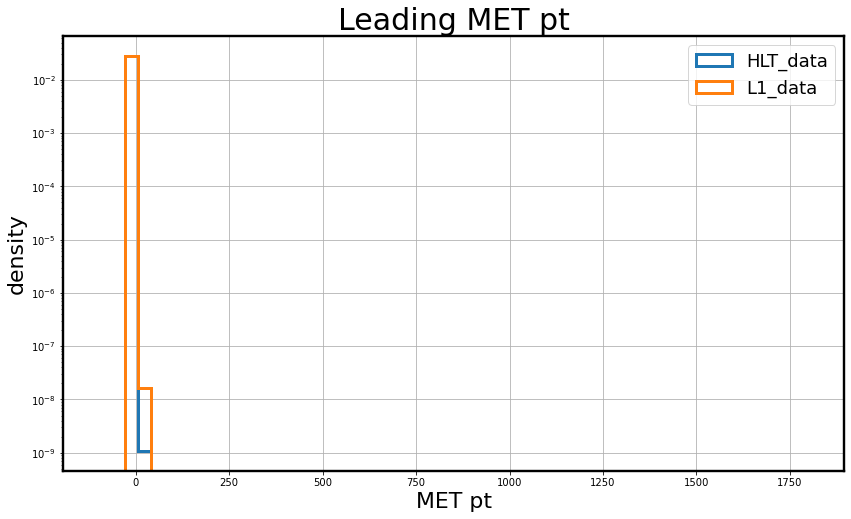

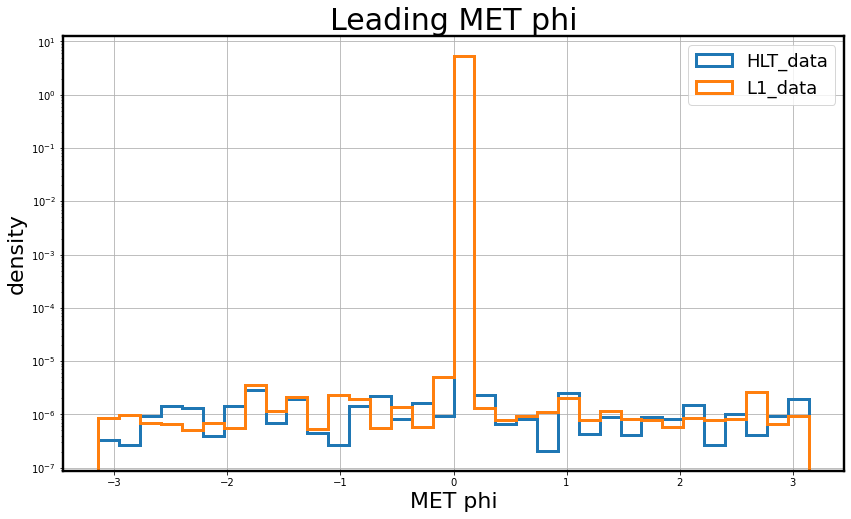

In [39]:
for obj in ['jets', 'electrons', 'muons', 'MET']:
    for var in ['pt', 'eta', 'phi']:
        if obj=='MET' and var=='eta': continue
        plot_kinematics(datasets, 'EB', var=var, object=obj)

In [72]:
def plot_2d_hist(data1, data2, weights, object, var='pt', bins=50, cmap='viridis', data1_name='data1', data2_name='data2', dataset_name='EB data'):
    """Plots a 2D histogram for the specified variables from given datasets."""

    plt.figure(figsize=(14, 8))
    plt.rcParams['axes.linewidth'] = 2.4
    
    #bins = {'pt': np.linspace(-100, 500, 35),
            #'eta': np.linspace(-5, 5, 35),
            #'phi': np.linspace(-np.pi, np.pi, 35)}
    bins=35

    idx_1 = {'jets': 0,
            'electrons': 10,
            'muons': 16,
            'photons': 22,
            'MET': 28}

    idx_2 = {'pt': 0,
            'eta': 1,
            'phi': 2}

    var_data1 = data1[:, idx_1[object], idx_2[var]]
    var_data2 = data2[:, idx_1[object], idx_2[var]]
    mask1 = var_data1 < 1000
    mask2 = var_data2 < 1000
    mask3 = (var_data1 == 0) & (var_data2 == 0)
    plt.hist2d(var_data1[mask1&mask2&~mask3], var_data2[mask1&mask2&~mask3], bins=bins, cmap=cmap, norm=matplotlib.colors.LogNorm(), weights=weights[mask1&mask2&~mask3])
    plt.colorbar()
    plt.xlabel(f'{data1_name} {object} {var}', fontsize=16)
    plt.ylabel(f'{data2_name} {object} {var}', fontsize=16)
    plt.title(f'{dataset_name}: {data1_name} vs {data2_name} Leading {object} {var}', fontsize=18)
    plt.show()

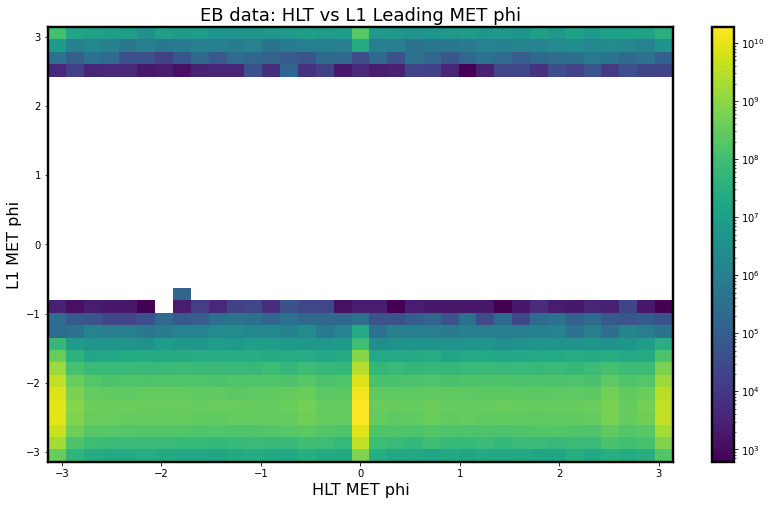

In [73]:
plot_2d_hist(datasets['EB']['HLT_data'], datasets['EB']['L1_data'], weights=datasets['EB']['weights'], object='MET', data1_name='HLT', data2_name='L1', var='phi')

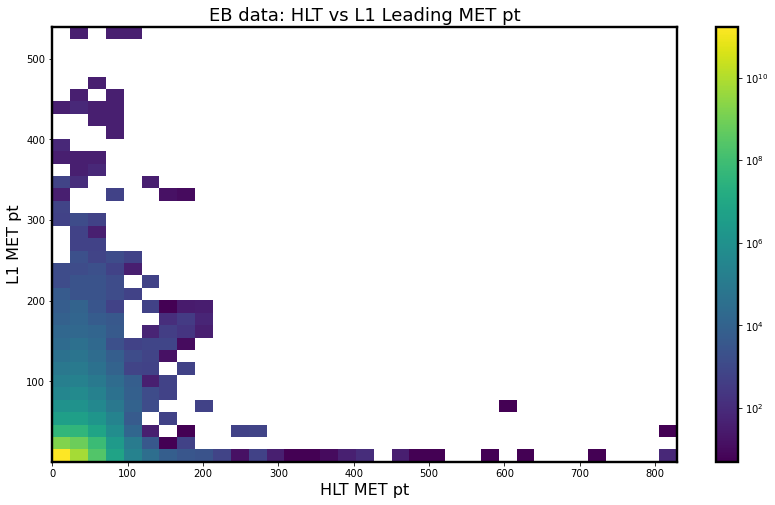

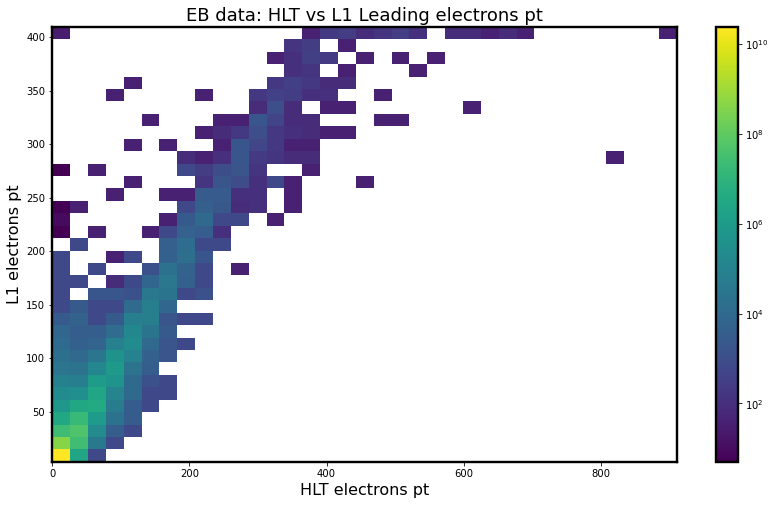

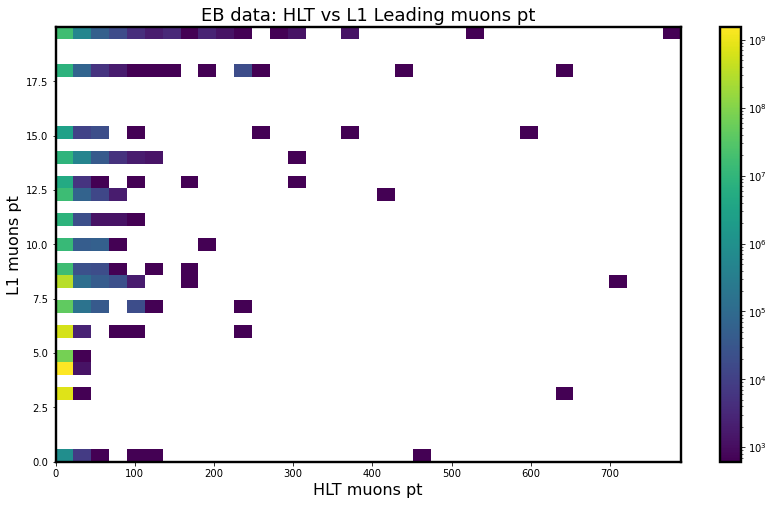

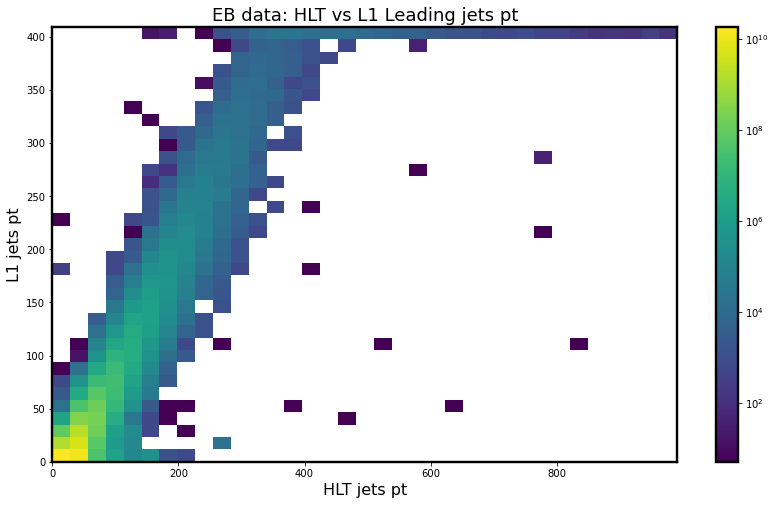

In [74]:
for obj in ['MET', 'electrons', 'muons', 'jets']:
    plot_2d_hist(datasets['EB']['HLT_data'], datasets['EB']['L1_data'], object=obj, data1_name='HLT', data2_name='L1', var='pt', weights=datasets['EB']['weights'])

## Below here was some old stuff I was looking at with a different file; just the MET px and py instead of magnitude

In [39]:
# source /cvmfs/sft.cern.ch/lcg/views/LCG_104/x86_64-centos7-gcc11-opt/setup.sh
import numpy as np
import ROOT
import math
import h5py
import xml.etree.ElementTree as ET

HLT_MET_px = []
HLT_MET_py = []
L1_MET_py = []
L1_MET_px = []

f = ROOT.TFile.Open("../../../../ntuples/EB_trees_05-16-2024/user.mmcohen.473255_06-07-2024_tree.root/user.mmcohen.00473255.39727868._000001.tree.root")
td = f.Get("EB_Tree")
tree = td.Get("nominal")
nevents = tree.GetEntries() # number of events
print(nevents)

for i, event in enumerate(tree):
    # HLT MET
    HLT_MET_px.append(np.float32(event.trigmetMetPx))
    HLT_MET_py.append(np.float32(event.trigmetMetPx))

    # L1 MET
    L1_MET_px.append(np.float32(event.L1METMetPx))
    L1_MET_py.append(np.float32(event.L1METMetPy))

    if i%10000 == 1:
        print(f'progress: {i} / {nevents}')

1011941
progress: 1 / 1011941
progress: 10001 / 1011941
progress: 20001 / 1011941
progress: 30001 / 1011941
progress: 40001 / 1011941
progress: 50001 / 1011941
progress: 60001 / 1011941
progress: 70001 / 1011941
progress: 80001 / 1011941
progress: 90001 / 1011941
progress: 100001 / 1011941
progress: 110001 / 1011941
progress: 120001 / 1011941
progress: 130001 / 1011941
progress: 140001 / 1011941
progress: 150001 / 1011941
progress: 160001 / 1011941
progress: 170001 / 1011941
progress: 180001 / 1011941
progress: 190001 / 1011941
progress: 200001 / 1011941
progress: 210001 / 1011941
progress: 220001 / 1011941
progress: 230001 / 1011941
progress: 240001 / 1011941
progress: 250001 / 1011941
progress: 260001 / 1011941
progress: 270001 / 1011941
progress: 280001 / 1011941
progress: 290001 / 1011941
progress: 300001 / 1011941
progress: 310001 / 1011941
progress: 320001 / 1011941
progress: 330001 / 1011941
progress: 340001 / 1011941
progress: 350001 / 1011941
progress: 360001 / 1011941
progres

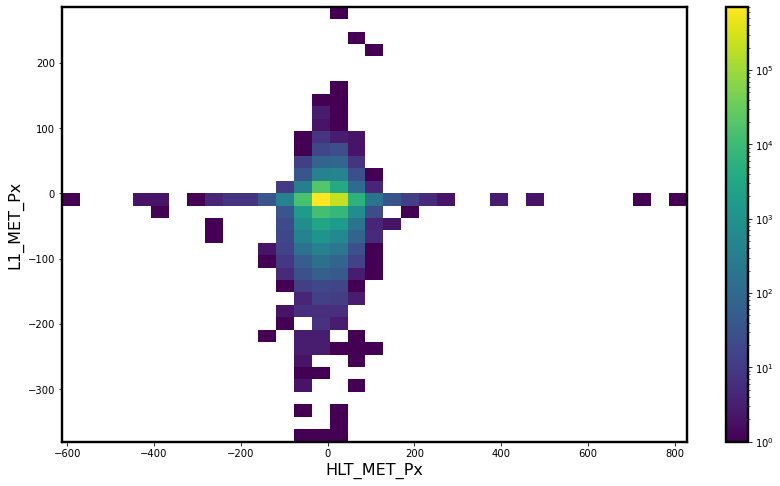

In [46]:
plt.figure(figsize=(14, 8))
plt.rcParams['axes.linewidth'] = 2.4
    
mask = (np.absolute(HLT_MET_px) < 1000) & (np.absolute(L1_MET_px) < 1000)
plt.hist2d(np.array(HLT_MET_px)[mask], np.array(L1_MET_px)[mask], bins=35, cmap='viridis', norm=matplotlib.colors.LogNorm(), weights=np.ones(len(np.array(HLT_MET_px)[mask])))
plt.colorbar()
plt.xlabel(f'HLT_MET_Px', fontsize=16)
plt.ylabel(f'L1_MET_Px', fontsize=16)
plt.show()

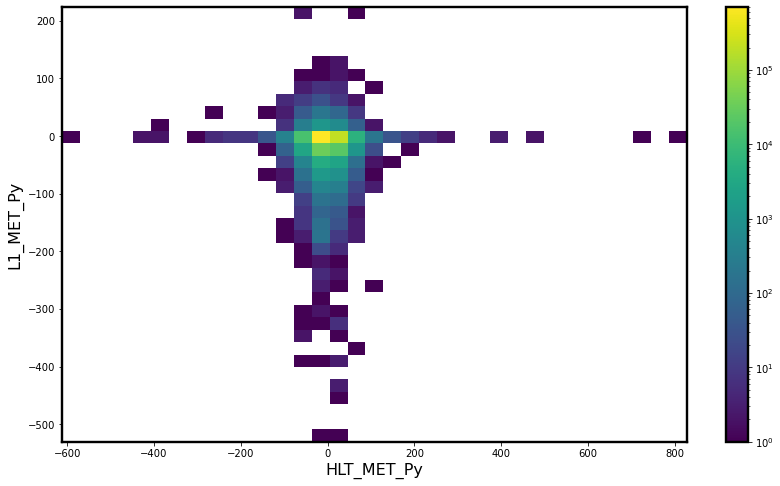

In [47]:
plt.figure(figsize=(14, 8))
plt.rcParams['axes.linewidth'] = 2.4
    
mask = (np.absolute(HLT_MET_py) < 1000) & (np.absolute(L1_MET_py) < 1000)
plt.hist2d(np.array(HLT_MET_py)[mask], np.array(L1_MET_py)[mask], bins=35, cmap='viridis', norm=matplotlib.colors.LogNorm(), weights=np.ones(len(np.array(HLT_MET_py)[mask])))
plt.colorbar()
plt.xlabel(f'HLT_MET_Py', fontsize=16)
plt.ylabel(f'L1_MET_Py', fontsize=16)
plt.show()

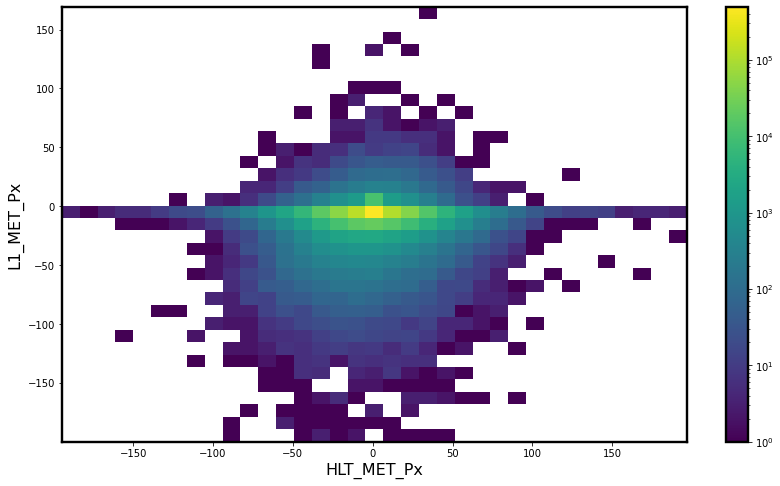

In [48]:
plt.figure(figsize=(14, 8))
plt.rcParams['axes.linewidth'] = 2.4
    
mask = (np.absolute(HLT_MET_px) < 200) & (np.absolute(L1_MET_px) < 200)
plt.hist2d(np.array(HLT_MET_px)[mask], np.array(L1_MET_px)[mask], bins=35, cmap='viridis', norm=matplotlib.colors.LogNorm(), weights=np.ones(len(np.array(HLT_MET_px)[mask])))
plt.colorbar()
plt.xlabel(f'HLT_MET_Px', fontsize=16)
plt.ylabel(f'L1_MET_Px', fontsize=16)
plt.show()